## Setup

In [1]:
from pathlib import Path
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import ast
import numpy as np
from numpy.random import default_rng
from typing import Tuple, Optional, Dict, Any

from src.utils import grid_search_dict

from fct import run_exp, pmmr_exp, kpv_exp, NMMR_exp, calc_haw, gen_haw, ha_effect, save_data

C:\Users\Benedikt\anaconda3new\envs\kompa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
experiment_name = "mastourie"
n_sample = 1000
beta = np.sqrt(0.05)
sigma = np.sqrt(3)
a_start = -2
a_end = 2

data_dic = {
      "name" : experiment_name,
      "n_sample" : n_sample,
      "beta": beta,
      "sigma": sigma,
      "a_start": a_start,
      "a_end": a_end,
}

pmmr_configs = {
        "name": "pmmr",
        "lam1": np.logspace(np.log10(1/(450)**2), np.log10(0.25), 50),
        "lam2": 0.01,
        "scale": 0.5,
        "data_scaling": True
}

kpv_configs = {
        "name": "kpv",
        "lam1_max": 0.01,
        "lam1_min":  0.0001,
        "n_lam1_search": 25,
        "lam2_max": 0.01,
        "lam2_min": 0.0001,
        "n_lam2_search": 25,
        "split_ratio": 0.5,
        "scale": 0.5,
        "data_scaling": True,
}

nmmr_u_configs = {
    "name": "nmmr",
    "n_epochs": [2000],
    "batch_size": 100,
    "log_metrics": "True",
    "learning_rate": [0.003],
    "l2_penalty": [3e-06],
    "loss_name": "U_statistic",
    "network_depth": [4],
    "network_width": [80]
}

nmmr_v_configs = {
    "name": "nmmr",
    "n_epochs": [2000],
    "batch_size": 100,
    "log_metrics": "True",
    "learning_rate": [0.003],
    "l2_penalty": [3e-06],
    "loss_name": "V_statistic",
    "network_depth": [3],
    "network_width": [80]
}

## Evaluations

#### Grid search is unfair for KPV!

In [3]:
%%time
sd_list = [5949, 7422, 4388, 2807, 5654, 5518, 1816, 1102, 9886, 1656, 
           4379, 2029, 8455, 4987, 4259, 2533, 9783, 7987, 1009, 2297]

sd_list = [5949, 7422, 4388, 2807, 5654, 5518, 1816, 1102, 9886, 1656]

# save results
results_pmmr = run_exp(model_config = pmmr_configs, data_config=data_dic, sd_list=sd_list)
print("PMMR finished")

PMMR finished
CPU times: total: 39min 11s
Wall time: 11min 16s


In [4]:
%%time
results_kpv = run_exp(model_config = kpv_configs, data_config=data_dic, sd_list=sd_list)
print("KPV finished")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


KPV finished
CPU times: total: 53min 34s
Wall time: 8min 7s


In [5]:
%%time
results_nmmr_u = run_exp(model_config = nmmr_u_configs, data_config=data_dic, sd_list=sd_list)
print("NMMR-U finished")

100%|██████████| 2000/2000 [04:03<00:00,  8.20it/s]


NMMR-U finished
CPU times: total: 2h 25min 57s
Wall time: 37min 35s


In [6]:
%%time
results_nmmr_v = run_exp(model_config = nmmr_v_configs, data_config=data_dic, sd_list=sd_list)
print("NMMR-V finished")
df_save = pd.DataFrame(columns=['model', 'pred_avg', 'train_data', 'test_data', 'pred_all', 
                                'mse_avg', 'mae_avg', 'mse_all', 'mae_all', 'param_opt', 'error', 
                                'std', 'error_abs', 'std_abs', 'model_config', 'data_config'])
df_save = df_save.append([results_pmmr, results_kpv, results_nmmr_u, results_nmmr_v])
save_data(df_save, data_dic)

100%|██████████| 2000/2000 [03:34<00:00,  9.33it/s]


NMMR-V finished
CPU times: total: 2h 22min 34s
Wall time: 36min 3s


In [16]:
df_save

,model,pred_avg,train_data,test_data,pred_all,mse_avg,mae_avg,mse_all,mae_all,param_opt,error,std,error_abs,std_abs,model_config,data_config,sd_list
0,pmmr,"[0.24913471943010618, 0.26953727793424614, 0.2...","([[0.7478640708285907], [1.8801353986039246], ...","([[-2.0], [-1.9595959595959596], [-1.919191919...","[[0.23986351810515188, 0.32673321629128527, 0....",0.222938,0.408841,"[0.20897400112325426, 0.2207820420579199, 0.21...","[0.39583520668192934, 0.37533797698795435, 0.4...","[0.0019309726158312913, 0.0002116906213593919,...","[[0.325861380384553, 0.2389916821984196, 0.291...","[[0.03821028074820824], [0.04072541378413003],...","[[0.325861380384553, 0.2389916821984196, 0.291...","[[0.03821028074820824], [0.04072541378413003],...","{'name': 'pmmr', 'lam1': [4.938271604938276e-0...","{'name': 'mastourie', 'n_sample': 1000, 'beta'...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."
1,kpv,"[0.8712803, 0.9209501, 0.9688026, 1.01424, 1.0...","([[0.7478640708285907], [1.8801353986039246], ...","([[-2.0], [-1.9595959595959596], [-1.919191919...","[[0.88352215, 0.8886413, 0.91345966, 0.4487004...",0.226392,0.407969,"[0.26435986, 0.2311557, 0.1552622, 0.13974564,...","[0.4571611, 0.41678023, 0.33585748, 0.2998635,...","[[0.01, 0.0001], [0.01, 0.0001], [0.01, 0.0001...","[[-0.31779725441099094, -0.32291639932752536, ...","[[0.14584845289996423], [0.15134806821855865],...","[[0.31779725441099094, 0.32291639932752536, 0....","[[0.08013111994169353], [0.11170161237381365],...","{'name': 'kpv', 'lam1_max': 0.01, 'lam1_min': ...","{'name': 'mastourie', 'n_sample': 1000, 'beta'...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."
2,nmmr_U_statistic,"[15.7673645, 15.078687, 14.402199, 13.741211, ...","([[0.7478640708285907], [1.8801353986039246], ...","([[-2.0], [-1.9595959595959596], [-1.919191919...","[[0.01938675, 0.37324855, 1.404365, 153.30165,...",224.171153,3.168993,"[0.5378077951620854, 0.4302194346960486, 0.357...","[0.7107880727986557, 0.5829639744652747, 0.540...","[{'name': 'nmmr', 'batch_size': 100, 'log_metr...","[[0.5463381487750919, 0.19247635117410733, -0....","[[45.851583738333076], [43.803307398162175], [...","[[0.5463381487750919, 0.19247635117410733, 0.8...","[[45.61390150786237], [43.57105634664418], [41...","{'name': 'nmmr', 'n_epochs': [2000], 'batch_si...","{'name': 'mastourie', 'n_sample': 1000, 'beta'...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."
3,nmmr_V_statistic,"[2.1718771, 2.1173656, 2.0627677, 2.0080879, 1...","([[0.7478640708285907], [1.8801353986039246], ...","([[-2.0], [-1.9595959595959596], [-1.919191919...","[[2.0762005, 2.4556825, 2.197025, 2.404915, 2....",0.436079,0.539334,"[0.42498696931847463, 0.5032604756130882, 0.43...","[0.5438650741466295, 0.5635439623889923, 0.529...","[{'name': 'nmmr', 'batch_size': 100, 'log_metr...","[[-1.5104755867397874, -1.8899576176083177, -1...","[[0.16892178029731958], [0.15835112954914055],...","[[1.5104755867397874, 1.8899576176083177, 1.63...","[[0.16892178029731958], [0.15835112954914055],...","{'name': 'nmmr', 'n_epochs': [2000], 'batch_si...","{'name': 'mastourie', 'n_sample': 1000, 'beta'...","[5949, 7422, 4388, 2807, 5654, 5518, 1816, 110..."


### Plot

#### Get Data

In [10]:
# results_pmmr = df_save[df_save["model"] == "pmmr"].to_dict(orient='records')[0]
# results_kpv = df_save[df_save["model"] == "kpv"].to_dict(orient='records')[0]
# results_nmmr_u = df_save[df_save["model"] == "nmmr_U_statistic"].to_dict(orient='records')[0]
# results_nmmr_v = df_save[df_save["model"] == "nmmr_V_statistic"].to_dict(orient='records')[0]

A_train = np.squeeze(results_pmmr["train_data"].treatment)
Y_train = np.squeeze(results_pmmr["train_data"].outcome)
A_test = np.squeeze(results_pmmr["test_data"].treatment)
Y_test = np.squeeze(results_pmmr["test_data"].structural)

Y_pred_pmmr = results_pmmr["pred_avg"]
Y_pred_kpv = results_kpv["pred_avg"]
Y_pred_nmmr_u = results_nmmr_u["pred_avg"]
Y_pred_nmmr_v = results_nmmr_v["pred_avg"]

std_pmmr = np.squeeze(results_pmmr["std"])
std_kpv = np.squeeze(results_kpv["std"])
std_nmmr_u = np.squeeze(results_nmmr_u["std"])
std_nmmr_v = np.squeeze(results_nmmr_v["std"])

std_pmmr_abs = np.squeeze(results_pmmr["std_abs"])
std_kpv_abs = np.squeeze(results_kpv["std_abs"])
std_nmmr_u_abs = np.squeeze(results_nmmr_u["std_abs"])
std_nmmr_v_abs = np.squeeze(results_nmmr_v["std_abs"])

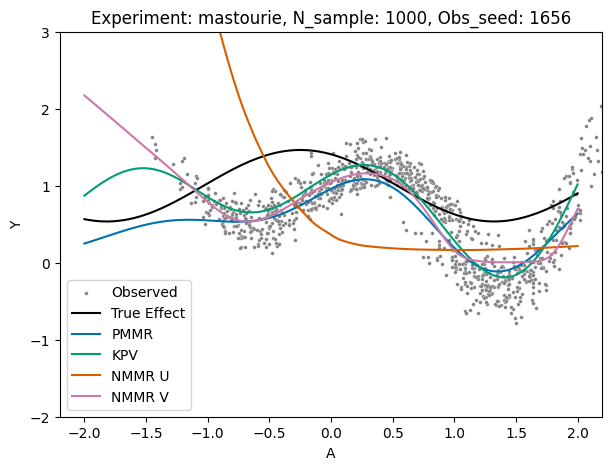

In [13]:
import importlib
importlib.reload(plt)


plt.style.use('seaborn-colorblind')
plt.figure(figsize=(7, 5))
# Obs & True values
sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7)
plt.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")

# Predictions
plt.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
plt.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
plt.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
plt.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

plt.title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
plt.xlabel('A')
plt.xlim([-2.2, 2.2])
plt.ylabel('Y')
plt.ylim([-2, 3])
plt.legend()
plt.savefig(f"plots/plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}", dpi = 300, format="pdf")
plt.show()

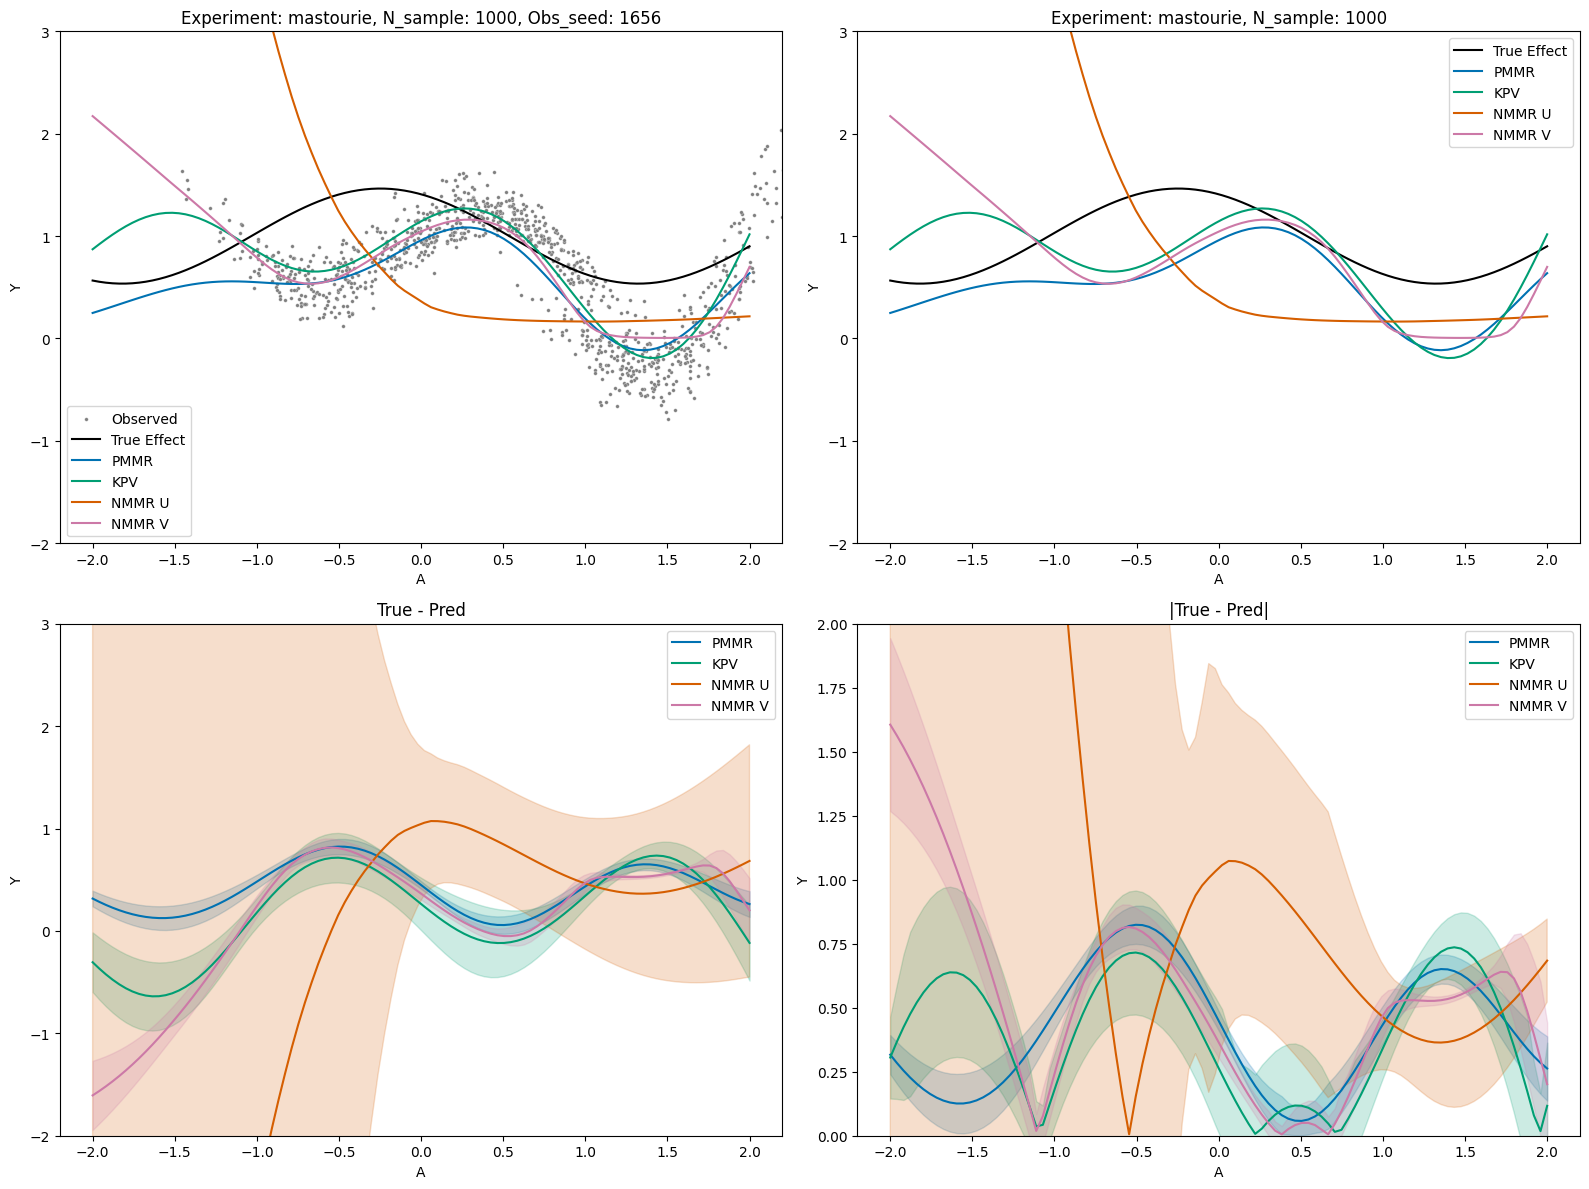

In [18]:
import importlib
importlib.reload(plt)

plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(2, 2, 1)
sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7, ax=ax1)
ax1.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
ax1.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
ax1.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
ax1.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
ax1.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

ax1.set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
ax1.set_xlabel('A')
ax1.set_xlim([-2.2, 2.2])
ax1.set_ylabel('Y')
ax1.set_ylim([-2, 3])
ax1.legend()

####

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
ax2.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
ax2.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
ax2.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
ax2.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

ax2.set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}')
ax2.set_xlabel('A')
ax2.set_xlim([-2.2, 2.2])
ax2.set_ylabel('Y')
ax2.set_ylim([-2, 3])
ax2.legend()

### True vs Pred
alpha = 0.2
ax3 = fig.add_subplot(2, 2, 3)
line, = ax3.plot(A_test, Y_test - Y_pred_pmmr,  label="PMMR", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_pmmr - 2*std_pmmr, Y_test - Y_pred_pmmr + 2*std_pmmr, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_kpv,  label="KPV", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_kpv - 2*std_kpv, Y_test - Y_pred_kpv + 2*std_kpv, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_nmmr_u - 2*std_nmmr_u, Y_test - Y_pred_nmmr_u + 2*std_nmmr_u, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_nmmr_v, label="NMMR V", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_nmmr_v - 2*std_nmmr_v, Y_test - Y_pred_nmmr_v + 2*std_nmmr_v, alpha=alpha, color=color)

ax3.set_title('True - Pred')
ax3.set_xlabel('A')
ax3.set_xlim([-2.2, 2.2])
ax3.set_ylabel('Y')
ax3.set_ylim([-2, 3])
ax3.legend()

#### | True - Pred|
alpha = 0.2
ax4 = fig.add_subplot(2, 2, 4)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_pmmr),  label="PMMR", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_pmmr) - 2*std_pmmr_abs, np.abs(Y_test - Y_pred_pmmr) + 2*std_pmmr_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_kpv),  label="KPV", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_kpv) - 2*std_kpv_abs, np.abs(Y_test - Y_pred_kpv) + 2*std_kpv_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_nmmr_u), label="NMMR U", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_nmmr_u) - 2*std_nmmr_u_abs, np.abs(Y_test - Y_pred_nmmr_u) + 2*std_nmmr_u_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_nmmr_v), label="NMMR V", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_nmmr_v) - 2*std_nmmr_v_abs, np.abs(Y_test - Y_pred_nmmr_v) + 2*std_nmmr_v_abs, alpha=alpha, color=color)

ax4.set_title('|True - Pred|')
ax4.set_xlabel('A')
ax4.set_xlim([-2.2, 2.2])
ax4.set_ylabel('Y')
ax4.set_ylim([0, 2])
ax4.legend()


###########
plt.tight_layout()
time_stamp = datetime.datetime.now()
time_string = time_stamp.strftime("%Y_%m_%d_%H_%M_%S")
plt.savefig(f"plots/all_plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}_n_seed_{len(sd_list)}_time_{time_string}", dpi = 300, format="pdf")
plt.show()


AxesSubplot(0.125,0.53;0.352273x0.35)
AxesSubplot(0.547727,0.53;0.352273x0.35)


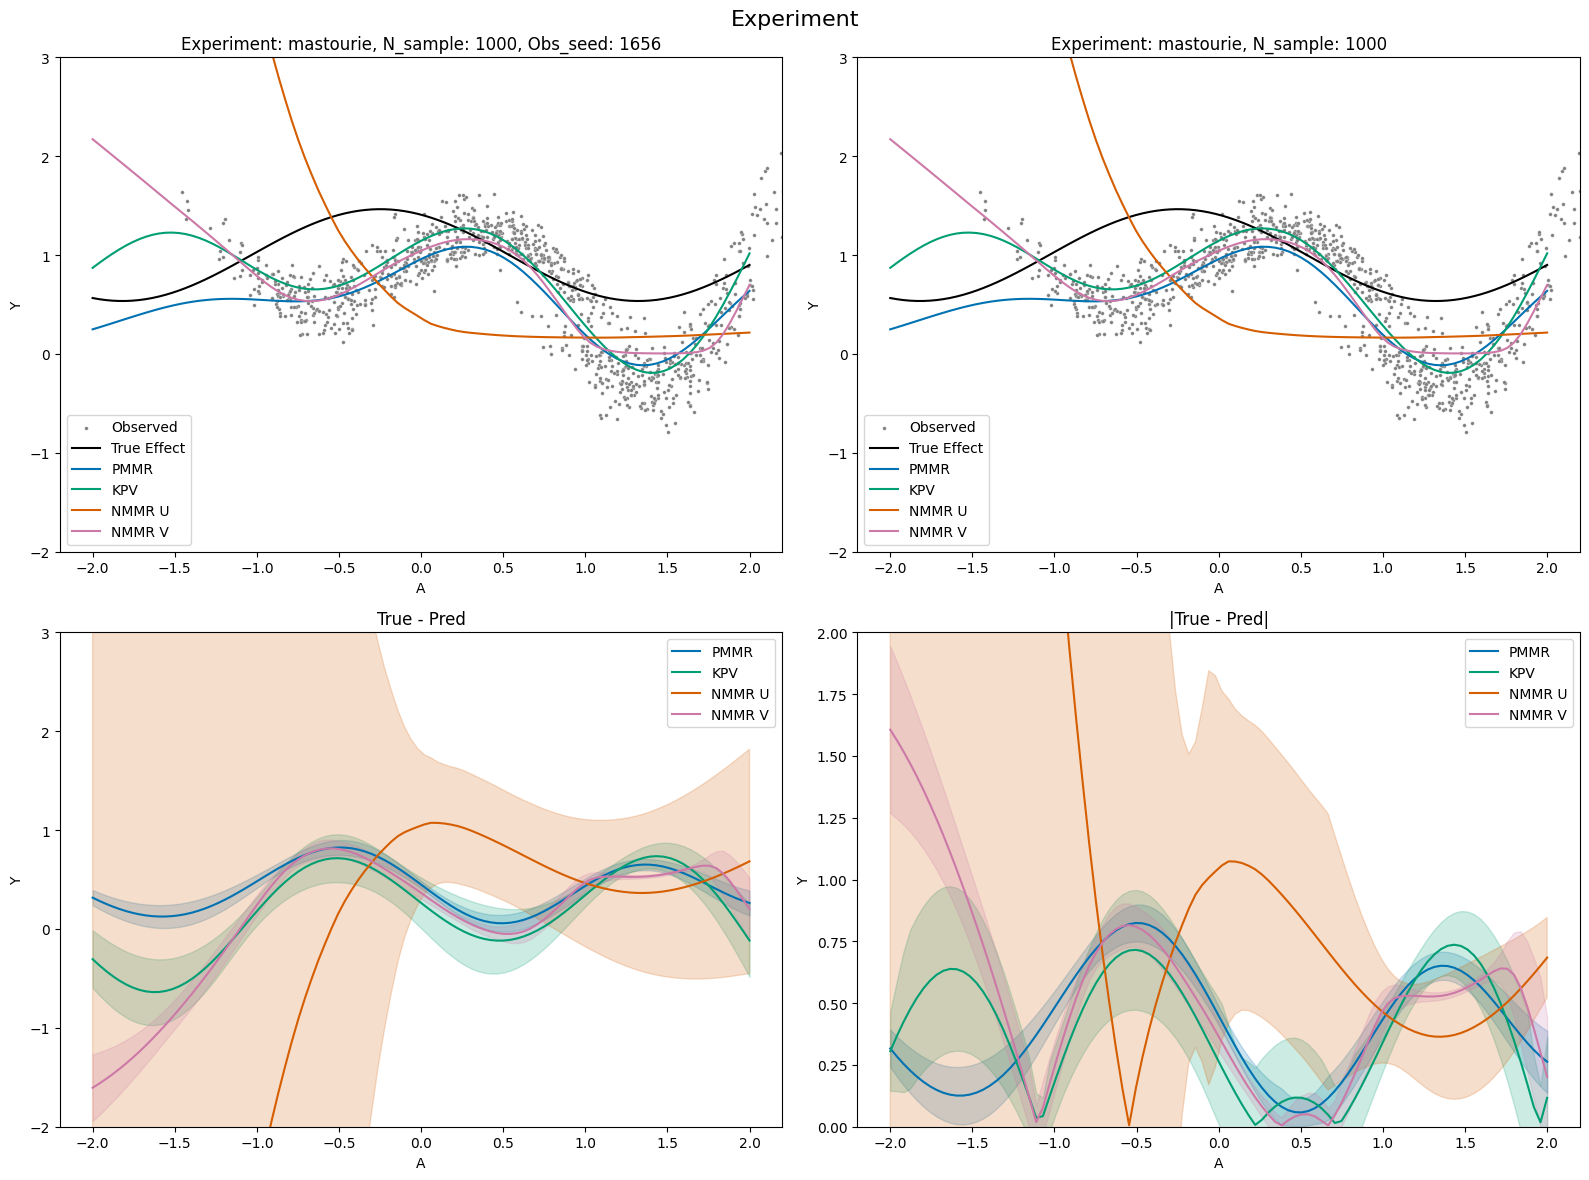

In [24]:
import importlib
importlib.reload(plt)

plt.style.use('seaborn-colorblind')

# Define common settings for all plots
x_limits = [-2.2, 2.2]
y_limits = [-2, 3]
alpha = 0.2

# Define reusable function for plots
def plot_and_fill(ax, x, y, std, label, linestyle="solid"):
    line, = ax.plot(x, y, label=label, linestyle=linestyle)
    color = line.get_color()
    ax.fill_between(x, y - 2*std, y + 2*std, alpha=alpha, color=color)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Experiment', fontsize=16)

# Create data structure for predictions and standard deviations
preds_and_stds = [
    (Y_pred_pmmr, std_pmmr, std_pmmr_abs, "PMMR"),
    (Y_pred_kpv, std_kpv, std_kpv_abs, "KPV"),
    (Y_pred_nmmr_u, std_nmmr_u, std_nmmr_u_abs, "NMMR U"),
    (Y_pred_nmmr_v, std_nmmr_v, std_nmmr_v_abs, "NMMR V")
]

# Draw first two subplots
for ax in axs[0]:
    sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7, ax=ax)
    ax.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
    
    for Y_pred, _, _, label in preds_and_stds:
        ax.plot(A_test, Y_pred, label=label)

    ax.set_xlabel('A')
    ax.set_xlim(x_limits)
    ax.set_ylabel('Y')
    ax.set_ylim(y_limits)
    ax.legend()

axs[0, 0].set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
axs[0, 1].set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}')

# Draw third subplot
for Y_pred, std, _, label in preds_and_stds:
    plot_and_fill(axs[1, 0], A_test, Y_test - Y_pred, std, label)

axs[1, 0].set_title('True - Pred')
axs[1, 0].set_xlabel('A')
axs[1, 0].set_xlim(x_limits)
axs[1, 0].set_ylabel('Y')
axs[1, 0].set_ylim(y_limits)
axs[1, 0].legend()

# Draw fourth subplot
for Y_pred, _, std_abs, label in preds_and_stds:
    plot_and_fill(axs[1, 1], A_test, np.abs(Y_test - Y_pred), std_abs, label)

axs[1, 1].set_title('|True - Pred|')
axs[1, 1].set_xlabel('A')
axs[1, 1].set_xlim(x_limits)
axs[1, 1].set_ylabel('Y')
axs[1, 1].set_ylim([0, 2])
axs[1, 1].legend()

plt.tight_layout()
time_stamp = datetime.datetime.now()
time_string = time_stamp.strftime("%Y_%m_%d_%H_%M_%S")
plt.savefig(f"plots/all_plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}_n_seed_{len(sd_list)}_time_{time_string}", dpi = 300, format="pdf")
plt.show()


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np

def generate_plots(data, x_limits, y_limits, axis_names, save_path, fig_size=(16, 12), style='seaborn-colorblind', seed_list=None, experiment_name=None, n_sample=None, alpha=0.2):
    plt.style.use(style)
    fig = plt.figure(figsize=fig_size)

    ax_titles = ['Experiment: {0}, N_sample: {1}, Obs_seed: {2}', 'Experiment: {0}, N_sample: {1}', 'True - Pred', '|True - Pred|']
    models = ['PMMR', 'KPV', 'NMMR U', 'NMMR V']

    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        
        # Common plots and settings
        for model in models:
            Y_pred = data['Y_pred_' + model.lower().replace(' ', '_')]
            if i == 0 and model == 'PMMR': # For the scatter plot in first subplot
                sns.scatterplot(x=data['A_train'], y=data['Y_train'], color='gray', label='Observed', s=7, ax=ax)
            if i < 2: # For first two subplots
                ax.plot(data['A_test'], Y_pred, label=model, linestyle="solid")
            elif i == 2: # For third subplot
                std = data['std_' + model.lower().replace(' ', '_')]
                line, = ax.plot(data['A_test'], data['Y_test'] - Y_pred, label=model, linestyle="solid")
                color = line.get_color()
                ax.fill_between(data['A_test'], data['Y_test'] - Y_pred - 2*std, data['Y_test'] - Y_pred + 2*std, alpha=alpha, color=color)
            elif i == 3: # For fourth subplot
                std_abs = data['std_' + model.lower().replace(' ', '_') + '_abs']
                line, = ax.plot(data['A_test'], np.abs(data['Y_test'] - Y_pred), label=model, linestyle="solid")
                color = line.get_color()
                ax.fill_between(data['A_test'], np.abs(data['Y_test'] - Y_pred) - 2*std_abs, np.abs(data['Y_test'] - Y_pred) + 2*std_abs, alpha=alpha, color=color)

        # Common settings
        ax.set_title(ax_titles[i].format(experiment_name, n_sample, seed_list[-1]) if i<2 else ax_titles[i])
        ax.set_xlabel(axis_names[0])
        ax.set_xlim(x_limits)
        ax.set_ylabel(axis_names[1])
        ax.set_ylim(y_limits if i!=3 else [0, 2]) # ylim differs for the last subplot
        ax.legend()

    plt.tight_layout()
    time_stamp = datetime.datetime.now()
    time_string = time_stamp.strftime("%Y_%m_%d_%H_%M_%S")
    plt.savefig(f"{save_path}/all_plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{seed_list[-1]}_n_seed_{len(seed_list)}_time_{time_string}", dpi = 300, format="pdf")
    plt.show()
